

# Objetivo

En este trabajo vamos a analizar los datos epidemiológicos generados por el grupo de trabajo [#escovid19data](https://github.com/montera34/escovid19data). Siguiendo los procesos estándares descargaremos los datos desde gitub, analizaremos los campos y prepararemos una serie de gráficas como ayuda para entender como estñá progresando la enfermedad.


@author: Manuel H. Arias 

@Twitter: @walyt

@mail: mharias@me.com



## Importación de librerias estándares para DAE

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.colors as colors

import numpy as np
from datetime import datetime,timedelta
import seaborn as sns
%matplotlib inline

import urllib.request

import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import itertools

## Descargamos la información

Hacemos en primer lugar una actualización de parámetros y preparación de variables que necesitaremos durante el ejercicio

In [2]:
pd.options.display.max_rows = 999 #Variable de contexto para permitir la presentación de datos por pantalla
pd.set_option('display.max_columns', None)

In [3]:
#fuente de pdatos
data_path = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Datos_Capacidad_Asistencial_Historico_30032021.csv'
data_path_row = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Datos_Capacidad_Asistencial_Historico_{}.csv'

img_path = '/Users/mharias/documents/proyectos/covid/sanidad_hospital/img/'
autor='@walyt'
escovid='@escovid19data'

In [4]:
hashtag_fuente='#escovid19data' #hashtag de la fuente para los créditos

In [5]:
hoy_string = datetime.today().strftime(format='%d %b')
hoy_string = datetime.today().strftime(format='%d%m%Y')

In [6]:
hoy_string

'06042021'

In [7]:
data_path = data_path_row.format(hoy_string)

In [8]:
data_path

'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Datos_Capacidad_Asistencial_Historico_06042021.csv'

Leemos los datos en un `pandas`

In [9]:
df = pd.read_csv(data_path,encoding = "ISO-8859-1",sep=';')

veamos una rápida descripción de la información:

In [10]:
df.tail()

,Fecha,Unidad,COD_CCAA,CCAA,Cod_Provincia,Provincia,TOTAL_CAMAS,OCUPADAS_COVID19,OCUPADAS_NO_COVID19
35863,05/04/2021,U. Críticas CON respirador,8,CASTILLA LA MANCHA,13,Ciudad Real,80,13,25
35864,05/04/2021,U. Críticas SIN respirador,1,ANDALUCÍA,14,Córdoba,59,0,7
35865,05/04/2021,U. Críticas SIN respirador,8,CASTILLA LA MANCHA,45,Toledo,18,0,10
35866,19/08/2020,Hospitalización convencional,9,CATALUÑA,43,Tarragona,2394,49,1755
35867,05/04/2021,U. Críticas SIN respirador,16,PAÍS VASCO,48,Bizkaia,10,2,5


In [11]:
df['Fecha'].unique()

array(['19/08/2020', '05/04/2021', '20/08/2020', '21/08/2020',
       '22/08/2020', '23/08/2020', '24/08/2020', '25/08/2020',
       '26/08/2020', '27/08/2020', '28/08/2020', '29/08/2020',
       '30/08/2020', '04/04/2021', '03/04/2021', '02/04/2021',
       '01/04/2021', '31/03/2021', '30/03/2021', '29/03/2021',
       '28/03/2021', '31/08/2020', '01/09/2020', '02/09/2020',
       '03/09/2020', '04/09/2020', '05/09/2020', '06/09/2020',
       '07/09/2020', '27/03/2021', '26/03/2021', '08/09/2020',
       '09/09/2020', '10/09/2020', '25/03/2021', '24/03/2021',
       '23/03/2021', '22/03/2021', '21/03/2021', '20/03/2021',
       '11/09/2020', '12/09/2020', '13/09/2020', '14/09/2020',
       '15/09/2020', '16/09/2020', '17/09/2020', '19/03/2021',
       '18/03/2021', '18/09/2020', '17/03/2021', '16/03/2021',
       '19/09/2020', '20/09/2020', '15/03/2021', '21/09/2020',
       '22/09/2020', '23/09/2020', '24/09/2020', '14/03/2021',
       '25/09/2020', '26/09/2020', '27/09/2020', '28/09

veamos las  columnas de interés:

In [12]:
df.columns

Index(['Fecha', 'Unidad', 'COD_CCAA', 'CCAA', 'Cod_Provincia', 'Provincia',
       'TOTAL_CAMAS', 'OCUPADAS_COVID19', 'OCUPADAS_NO_COVID19'],
      dtype='object')

In [13]:
df.Unidad.unique()

array(['Hospitalización convencional', 'U. Críticas CON respirador',
       'U. Críticas SIN respirador'], dtype=object)

In [14]:
df.CCAA.unique()

array(['ANDALUCÍA', 'CASTILLA Y LEÓN', 'CATALUÑA', 'LA RIOJA',
       'EXTREMADURA', 'ASTURIAS', 'PAÍS VASCO', 'ARAGÓN',
       'COMUNIDAD VALENCIANA', 'CASTILLA LA MANCHA', 'MURCIA',
       'ISLAS BALEARES', 'ISLAS CANARIAS', 'MADRID', 'CEUTA', 'NAVARRA',
       'MELILLA', 'CANTABRIA', 'GALICIA'], dtype=object)

Parece que es ok, no hay nombres duplicados (muy usual que cambie algún acento por ejemplo)

Convertimos la columna `fecha` en datetime

In [15]:
df['Fecha'] = pd.to_datetime(df['Fecha'],format='%d/%m/%Y')

y vamos añadir dos columnas adicionales `hola` : 
- `porcentaje_total`:  `OCUPADAS_COVID19`+`OCUPADAS_NO_COVID19` / `TOTAL_CAMAS` 
- `porcentaje_covid`: `OCUPADAS_COVID19`/ `TOTAL_CAMAS`

In [16]:
(df['Provincia']=='Madrid').any()

True

In [17]:
provincias = sorted(list(df['Provincia'].unique()))
provincias.insert(0,provincias.pop(-1))

In [18]:
fechas = df['Fecha'].unique()
unidades = df['Unidad'].unique()
for i in itertools.product(fechas,provincias,unidades):
    if ((df['Fecha']==i[0])&(df['Provincia']==i[1])&(df['Unidad']==i[2])).any():
        pass
    else:
        print (i)
        df=df.append({
            'Fecha':i[0],
            'Provincia':i[1],
            'Unidad':i[2],
            'TOTAL_CAMAS':np.NaN,
            'OCUPADAS_COVID19':np.NaN,
            'OCUPADAS_COVID19':np.NaN
        },
            ignore_index=True
        )

(numpy.datetime64('2021-04-03T00:00:00.000000000'), 'Palencia', 'Hospitalización convencional')
(numpy.datetime64('2021-04-03T00:00:00.000000000'), 'Palencia', 'U. Críticas CON respirador')
(numpy.datetime64('2021-04-03T00:00:00.000000000'), 'Palencia', 'U. Críticas SIN respirador')
(numpy.datetime64('2020-12-08T00:00:00.000000000'), 'Palencia', 'Hospitalización convencional')
(numpy.datetime64('2020-12-08T00:00:00.000000000'), 'Palencia', 'U. Críticas CON respirador')
(numpy.datetime64('2020-12-08T00:00:00.000000000'), 'Palencia', 'U. Críticas SIN respirador')
(numpy.datetime64('2021-01-02T00:00:00.000000000'), 'Palencia', 'Hospitalización convencional')
(numpy.datetime64('2021-01-02T00:00:00.000000000'), 'Palencia', 'U. Críticas CON respirador')
(numpy.datetime64('2021-01-02T00:00:00.000000000'), 'Palencia', 'U. Críticas SIN respirador')
(numpy.datetime64('2021-01-03T00:00:00.000000000'), 'Ceuta', 'Hospitalización convencional')
(numpy.datetime64('2021-01-03T00:00:00.000000000'), 'Ce

In [19]:
df.tail()

,Fecha,Unidad,COD_CCAA,CCAA,Cod_Provincia,Provincia,TOTAL_CAMAS,OCUPADAS_COVID19,OCUPADAS_NO_COVID19
35875,2021-01-02,U. Críticas CON respirador,NaN,NaN,NaN,Palencia,NaN,NaN,NaN
35876,2021-01-02,U. Críticas SIN respirador,NaN,NaN,NaN,Palencia,NaN,NaN,NaN
35877,2021-01-03,Hospitalización convencional,NaN,NaN,NaN,Ceuta,NaN,NaN,NaN
35878,2021-01-03,U. Críticas CON respirador,NaN,NaN,NaN,Ceuta,NaN,NaN,NaN
35879,2021-01-03,U. Críticas SIN respirador,NaN,NaN,NaN,Ceuta,NaN,NaN,NaN


In [20]:
df[df['Provincia']=='Palencia'].sort_values('Fecha')

,Fecha,Unidad,COD_CCAA,CCAA,Cod_Provincia,Provincia,TOTAL_CAMAS,OCUPADAS_COVID19,OCUPADAS_NO_COVID19
1214,2020-08-19,U. Críticas CON respirador,7.0,CASTILLA Y LEÓN,34.0,Palencia,14.0,0.0,12.0
707,2020-08-19,Hospitalización convencional,7.0,CASTILLA Y LEÓN,34.0,Palencia,331.0,6.0,252.0
711,2020-08-19,U. Críticas SIN respirador,7.0,CASTILLA Y LEÓN,34.0,Palencia,0.0,0.0,0.0
908,2020-08-20,U. Críticas SIN respirador,7.0,CASTILLA Y LEÓN,34.0,Palencia,0.0,0.0,0.0
524,2020-08-20,Hospitalización convencional,7.0,CASTILLA Y LEÓN,34.0,Palencia,329.0,5.0,263.0
1098,2020-08-20,U. Críticas CON respirador,7.0,CASTILLA Y LEÓN,34.0,Palencia,14.0,0.0,11.0
1045,2020-08-21,U. Críticas SIN respirador,7.0,CASTILLA Y LEÓN,34.0,Palencia,0.0,0.0,0.0
1103,2020-08-21,Hospitalización convencional,7.0,CASTILLA Y LEÓN,34.0,Palencia,329.0,4.0,238.0
1164,2020-08-21,U. Críticas CON respirador,7.0,CASTILLA Y LEÓN,34.0,Palencia,14.0,0.0,10.0
280,2020-08-22,Hospitalización convencional,7.0,CASTILLA Y LEÓN,34.0,Palencia,329.0,4.0,238.0


In [21]:
df['porcentaje_total'] = 100*(df['OCUPADAS_COVID19']+df['OCUPADAS_NO_COVID19'])/df['TOTAL_CAMAS']
df['porcentaje_covid'] = 100*(df['OCUPADAS_COVID19'])/df['TOTAL_CAMAS']

In [22]:
df=df.fillna(0)

# Gráficos

 A continuación vamos a crear un gráfico múltiple que nos permita visualizar cada una de las columnas con datos numéricos. Ello nos permitirá

Preparemos un gráfico tipo [Facetgrid](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html), al que añadiremos tantos gráficos como provincias, presentando una de las columnas de datos. Elegimos nº de hospitalizados por 100.000 habitantes. Dejo otras claves con `#` para que fácilmente se puedan generar. Este ejemplo esta basado en el código del link anterior.

In [23]:
datos1 = pd.melt(df[df['Unidad']=='Hospitalización convencional'], id_vars=['Fecha','Provincia'],value_vars=['porcentaje_total','porcentaje_covid'])

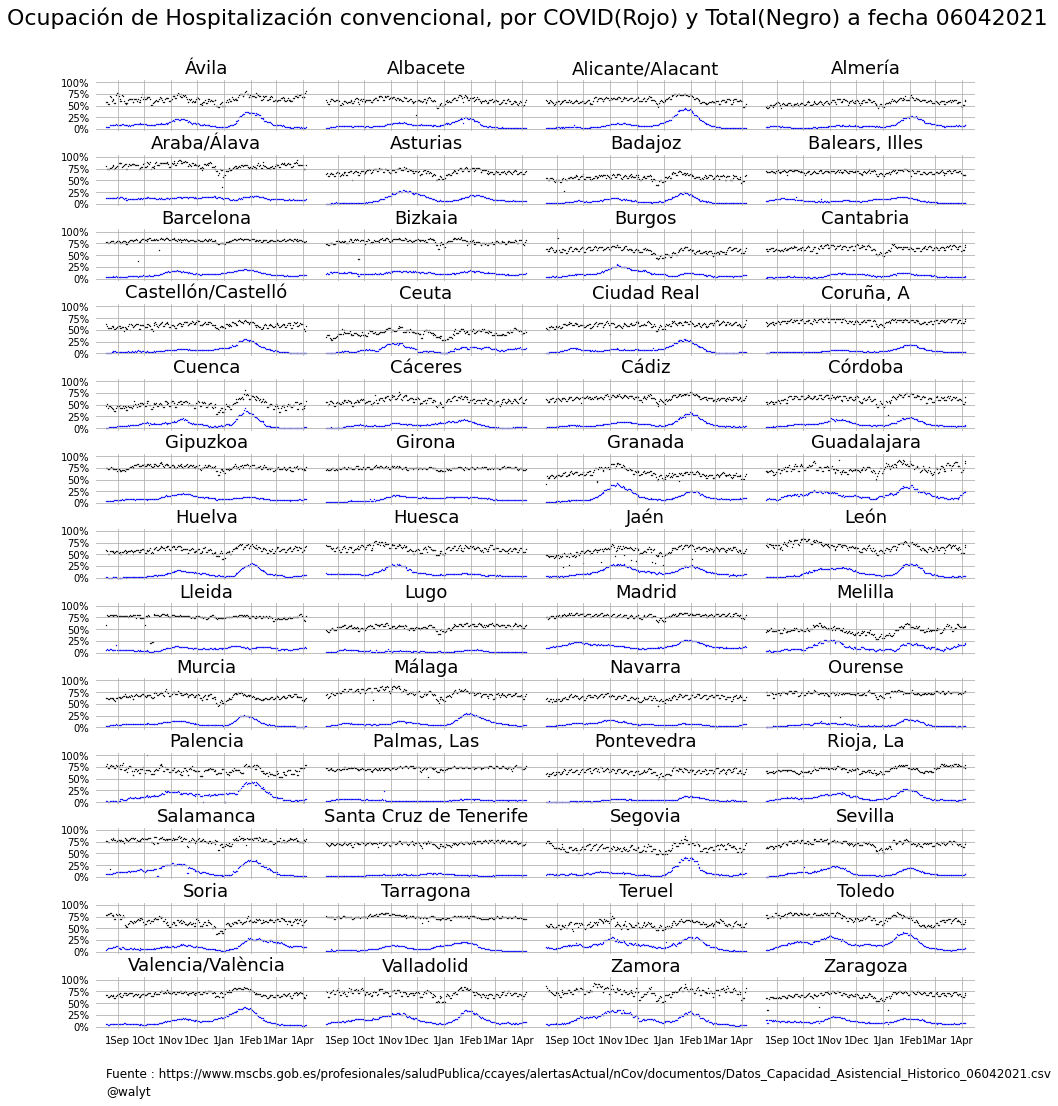

In [24]:
sns.plotting_context('paper', font_scale = 1.3)
g = sns.FacetGrid(datos1,col='Provincia',hue='variable',col_wrap=4,aspect=2.5, 
                      margin_titles=False,height=1.3,sharey=True,col_order=provincias,palette=['Black','Blue'])
g.map_dataframe(sns.scatterplot, x="Fecha", y="value",s=2)

# Título
unidad = 'Hospitalización convencional'
#unidad = 'U. Críticas CON respirador'
#unidad = 'U. Críticas SIN respirador'
titulo1 = 'Ocupación de {}, por COVID(Rojo) y Total(Negro) a fecha {}'.format(unidad,hoy_string)
titulo2 = 'Fuente : {}'.format(data_path)

color_ejes = 'black'
color_titulos = 'black'
color_total='black'
color_covid='red'

g.set_titles(row_template="{row_name}", col_template="{col_name}",size=18)
XmajorFmt = DateFormatter('%-d%-b')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = ticker.FormatStrFormatter(fmt)
for ax in g.axes.flat:
    
    ax.yaxis.set_major_formatter(yticks)
    ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
    #a1.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(XmajorFmt)
    ax.set_yticks([0,25,50,75,100])
    ax.xaxis.set_major_locator(DayLocator([1]))
    ax.grid(True,axis='both',which='both')
   


#plt.legend()
#g.set(yticks=[])
g.set(xlabel='')

g.despine(bottom=True, left=True)
g.fig.suptitle('{}'.format(titulo1),fontsize=22,color=color_titulos)
#g.fig.text(x=.4,y=.05,s='ROJO: CAMAS UCI COVID vs UCI TOTALES',color='red',fontsize=18)
#g.fig.text(x=.4,y=.1,s='AZUL: CAMAS HOSP COVID vs CAMAS TOTALES',color='navy',fontsize=18)
g.fig.text(x=0.05,y=.1,s=titulo2,color=color_titulos,fontsize=12,ha='left')
g.fig.text(x=0.05,y=.085,s=autor,color=color_titulos,fontsize=12)
g.fig.subplots_adjust(top=.92,bottom=.14,wspace=0.0,hspace=0.45)
#plt.tight_layout()
plt.savefig(img_path+unidad+'_provincias.png',dpi=288)  

plt.show()


# Graficos de UCI acumulados con respirador y sin respirador

In [25]:
datos2 = df.copy()

In [26]:
for i in itertools.product(fechas,provincias):
    
    
    
    camas_sin = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas SIN respirador')]['TOTAL_CAMAS'].values[0]
    camas_con = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas CON respirador')]['TOTAL_CAMAS'].values[0]
    ocupadas_covid_sin = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas SIN respirador')]['OCUPADAS_COVID19'].values[0]
    ocupadas_covid_con = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas CON respirador')]['OCUPADAS_COVID19'].values[0]
    ocupadas_no_covid_sin = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas SIN respirador')]['OCUPADAS_NO_COVID19'].values[0]
    ocupadas_no_covid_con = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas CON respirador')]['OCUPADAS_NO_COVID19'].values[0]
    datos2=datos2.append({
        'Fecha':i[0],
        'Provincia':i[1],
        'TOTAL_CAMAS':camas_sin+camas_con,
        'OCUPADAS_NO_COVID19':ocupadas_no_covid_sin+ocupadas_no_covid_con,
        'OCUPADAS_COVID19':ocupadas_covid_sin+ocupadas_covid_con,
        'Unidad':'U. Crítica Total'
        
    },ignore_index=True)

In [27]:
datos2['porcentaje_total'] = 100*(datos2['OCUPADAS_COVID19']+datos2['OCUPADAS_NO_COVID19'])/datos2['TOTAL_CAMAS']
datos2['porcentaje_covid'] = 100*datos2['OCUPADAS_COVID19']/datos2['TOTAL_CAMAS']
datos2=datos2.fillna(0)

In [28]:
datos3 = datos2[datos2['Unidad']=='U. Crítica Total']

In [29]:
datos3 = pd.melt(datos3, id_vars=['Fecha','Provincia'],value_vars=['porcentaje_total','porcentaje_covid'])

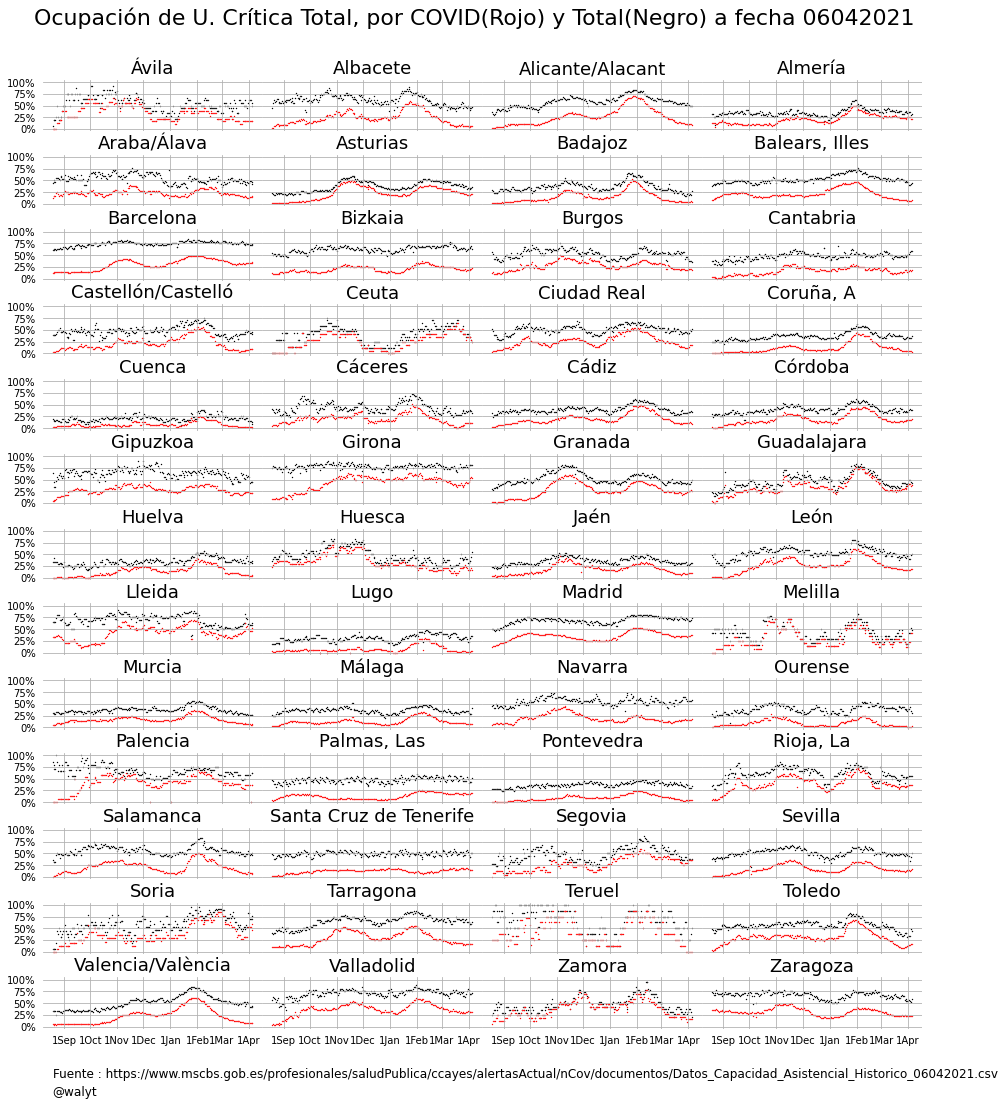

In [30]:
sns.plotting_context('paper', font_scale = 1.3)
g = sns.FacetGrid(datos3,col='Provincia',hue='variable',col_wrap=4,aspect=2.5, 
                      margin_titles=False,height=1.3,sharey=True,col_order=provincias,palette=['Black','Red'])
g.map_dataframe(sns.scatterplot, x="Fecha", y="value",s=2)
unidad = 'U. Crítica Total'
titulo1 = 'Ocupación de {}, por COVID(Rojo) y Total(Negro) a fecha {}'.format(unidad,hoy_string)
titulo2 = 'Fuente : {}'.format(data_path)
color_ejes = 'black'
color_titulos = 'black'
color_total='black'
color_covid='red'

g.set_titles(row_template="{row_name}", col_template="{col_name}",size=18)
XmajorFmt = DateFormatter('%-d%-b')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = ticker.FormatStrFormatter(fmt)
for ax in g.axes.flat:
    
    ax.yaxis.set_major_formatter(yticks)
    ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
    #a1.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(XmajorFmt)
    ax.set_yticks([0,25,50,75,100])
    ax.xaxis.set_major_locator(DayLocator([1]))
    ax.grid(True,axis='both',which='both')
   


#plt.legend()
#g.set(yticks=[])
g.set(xlabel='')

g.despine(bottom=True, left=True)
g.fig.suptitle('{}'.format(titulo1),fontsize=22,color=color_titulos)
#g.fig.text(x=.4,y=.05,s='ROJO: CAMAS UCI COVID vs UCI TOTALES',color='red',fontsize=18)
#g.fig.text(x=.4,y=.1,s='AZUL: CAMAS HOSP COVID vs CAMAS TOTALES',color='navy',fontsize=18)
g.fig.text(x=0.05,y=.1,s=titulo2,color=color_titulos,fontsize=12,ha='left')
g.fig.text(x=0.05,y=.085,s=autor,color=color_titulos,fontsize=12)
g.fig.subplots_adjust(top=.92,bottom=.14,wspace=0.0,hspace=0.45)
#plt.tight_layout()
plt.savefig(img_path+unidad+'_provincias.png',dpi=288)  

plt.show()
